In [4]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
%matplotlib inline

In [2]:
import sys

In [3]:
sys.path.pop(1)

'/opt/ros/kinetic/lib/python2.7/dist-packages'

In [64]:
dir_basis = '/home/divserge/Desktop/seq-01/'
files = sorted([file for file in os.listdir(dir_basis) if file.split('.')[-2] == 'color' 
                and file.split('.')[-1] == 'png'])[:100]

def create_orb_features(dir_basis, files):
    for i, file in enumerate(files):
        print(i, file)

        filename = dir_basis + file

        img = cv.imread(filename)
        gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        orb = cv.xfeatures2d.SIFT_create()

        kp, descriptors = orb.detectAndCompute(gray, None)

        temp = [(point.pt, point.size, point.angle, point.response, point.octave, 
            point.class_id, desc) for point, desc in zip(kp, descriptors)]

        with open(filename[:-3] + 'pckl', 'wb') as file:
            pickle.dump(temp, file)

In [65]:
create_orb_features(dir_basis, files)

0 frame-000000.color.png
1 frame-000001.color.png
2 frame-000002.color.png
3 frame-000003.color.png
4 frame-000004.color.png
5 frame-000005.color.png
6 frame-000006.color.png
7 frame-000007.color.png
8 frame-000008.color.png
9 frame-000009.color.png
10 frame-000010.color.png
11 frame-000011.color.png
12 frame-000012.color.png
13 frame-000013.color.png
14 frame-000014.color.png
15 frame-000015.color.png
16 frame-000016.color.png
17 frame-000017.color.png
18 frame-000018.color.png
19 frame-000019.color.png
20 frame-000020.color.png
21 frame-000021.color.png
22 frame-000022.color.png
23 frame-000023.color.png
24 frame-000024.color.png
25 frame-000025.color.png
26 frame-000026.color.png
27 frame-000027.color.png
28 frame-000028.color.png
29 frame-000029.color.png
30 frame-000030.color.png
31 frame-000031.color.png
32 frame-000032.color.png
33 frame-000033.color.png
34 frame-000034.color.png
35 frame-000035.color.png
36 frame-000036.color.png
37 frame-000037.color.png
38 frame-000038.color.

In [66]:
def deserialize_keypoint(point):
    return cv.KeyPoint(x=point[0][0],y=point[0][1],_size=point[1], _angle=point[2], 
                            _response=point[3], _octave=point[4], _class_id=point[5]), point[6]

In [67]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv.FlannBasedMatcher(index_params,search_params)

In [68]:
flann = cv.FlannBasedMatcher(index_params, {})

In [69]:
def get_keypoints(image_file):
    kp1, desc1 = [], []
    with open(image_file[:-3] + 'pckl', 'rb') as file:
        for entry in pickle.load(file):
            k, d = deserialize_keypoint(entry)
            kp1.append(k)
            desc1.append(d)       
    return kp1, np.array(desc1)

In [70]:
fname1 = dir_basis + files[0]
fname2 = dir_basis + files[1]
kp1, desc1 = get_keypoints(fname1)
kp2, desc2 = get_keypoints(fname2)

In [71]:
matches = flann.knnMatch(desc1,desc2,k=2)

In [72]:
matchesMask = [[0,0] for i in range(len(matches))]

good = []
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [73]:
draw_params = {
    'matchColor' : (0,255,0),
    'singlePointColor' : (255,0,0),
    'matchesMask' : matchesMask,
    'flags' : 0
}

In [74]:
img1 = cv.imread(fname1)
img2 = cv.imread(fname2)

In [75]:
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None, **draw_params)

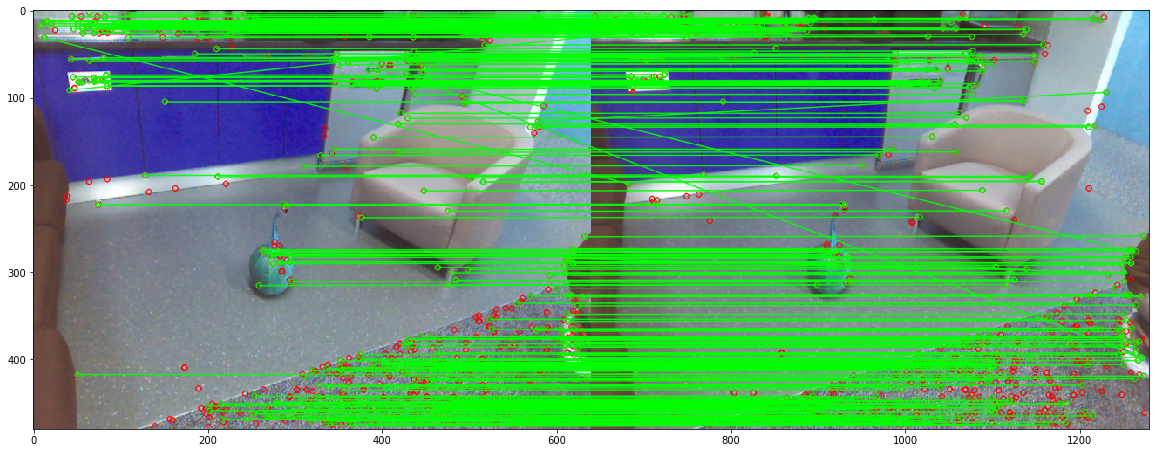

In [76]:
plt.figure(figsize=(20, 10))
plt.imshow(img3)

In [77]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

In [78]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c, _ = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1, img2

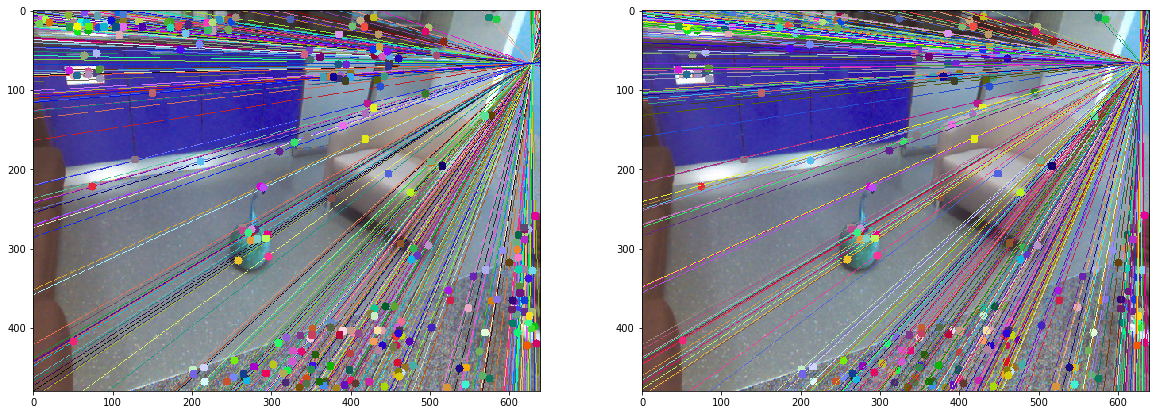

In [164]:
plt.figure(figsize=(20, 10))
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

In [256]:
K = np.array([
    [585.0, 0., 320],
    [0., 585, 240],
    [0, 0, 1]
])

In [257]:
from itertools import product

def find_correspondences(files):
    # TODO: Save fundamental matrices
    # How to take out 
    
    fname0 = files[0]
    kp0, desc0 = get_keypoints(fname0)
    pts_correspondence = {}

    for i in range(len(files))[1:]:

        fname1 = files[i]
        kp1, desc1 = get_keypoints(fname1)

        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(desc0,desc1,k=2)

        matchesMask = [[0,0] for i in range(len(matches))]

        good = []
        pts1 = []
        pts2 = []

        # ratio test as per Lowe's paper
        for j, p in enumerate(matches):
            try:
                m, n = p
            except:
                continue
            if m.distance < 0.8 * n.distance:
                matchesMask[j] = [1, 0]
                good.append(m)
                pts2.append(kp1[m.trainIdx])
                pts1.append(kp0[m.queryIdx])

        pts1_coord = np.int32([kp.pt for kp in pts1])
        pts2_coord = np.int32([kp.pt for kp in pts2])

        F, mask = cv.findFundamentalMat(pts1_coord, pts2_coord, cv.FM_RANSAC)
        
        pts1 = np.array(pts1)[mask.ravel() == 1]
        pts2 = np.array(pts2)[mask.ravel() == 1]
        
        pts1_coord = pts1_coord[mask.ravel() == 1]
        pts2_coord = pts2_coord[mask.ravel() == 1]
        
        E, mask = cv.findEssentialMat(pts1_coord, pts2_coord, K)
        T = np.eye(4)
        _, R, t, _ = cv.recoverPose(E, pts1_coord, pts2_coord, K, mask=mask)
        T[:3, :3] = R
        T[:-1, -1] = t.reshape(-1)
        
        pts_correspondence[(i-1, i)] = (pts1.copy(), pts2.copy(), T.copy())

        kp0, desc0 = kp1, desc1
        
    return pts_correspondence

pts_correspondence = find_correspondences([dir_basis + file for file in files])

In [261]:
poses_fake = [poses_true[0]]
for i in range(len(files) - 1):
    poses_fake.append(pts_correspondence[i, i + 1][-1] @ poses_fake[-1])

In [259]:
tracks = [[True, 0, [pt1, pt2]] for pt1, pt2 in zip(*pts_correspondence[(0, 1)][:-1])]

In [260]:
for i in range(1, len(files) - 1):
    
    if i % 50 == 0:
        print(i)
        print(len(tracks))
        
    taken_points = np.zeros_like(pts_correspondence[(i, i + 1)][0], dtype=bool)
    
    for track in tracks:
        
        has_match = False
        kp = track[-1][-1]
        
        if track[0] == False:
            continue

        for j, kp1 in enumerate(pts_correspondence[(i, i + 1)][0]):
            if np.linalg.norm(np.array(kp.pt) - np.array(kp1.pt)) < kp.size:
                taken_points[j] = True
                if has_match:
                    continue
                has_match = True
                track[-1].append(pts_correspondence[(i, i + 1)][1][j])
        
        track[0] = has_match
    
    for kp_index in np.where(taken_points == False)[0]:
        tracks.append([True, i, [
            pts_correspondence[(i, i + 1)][0][kp_index],
            pts_correspondence[(i, i + 1)][1][kp_index]
        ]])

50
4103


In [262]:
lengths = [len(track[2]) for track in tracks]
# first entry - finish flag (auxilary stuff)
# second entry - the first frame where the point appears
# third entry - list of keypoints on subsequent images

In [254]:
def get_poses(filename):
    poses = []
    with open(filename, 'r') as file:
        for line in file:
            if line[0] == '#':
                continue
            poses.append([float(el) for el in line.split()[1:]])
    return np.array(poses)

In [255]:
def get_calibration_matrix(filename):
    with open(filename, 'r') as file:
        for line in file:
            pass
    data = [float(el) for el in line.split()]
    matrix = np.diag(data[:2] + [1])
    matrix[:-1, -1] = data[-2:]
    return matrix

In [87]:
#K = get_calibration_matrix('./00_input/intrinsics.txt')

In [142]:
#pose_files = sorted([fname.split('.')[0] + '.pose.txt' for fname in files])
#poses_true = [np.loadtxt(dir_basis + pose_file) for pose_file in pose_files]

In [139]:
#poses_true = get_poses('./00_input/known_poses.txt')

In [263]:
def quaternion_matrix(quaternion):
    q = np.array(quaternion, dtype=np.float64, copy=True)
    n = np.dot(q, q)
    if n < 1e-6:
        return np.identity(4)
    q *= np.sqrt(2.0 / n)
    q = np.outer(q, q)
    return np.array([
        [1.0-q[2, 2]-q[3, 3],     q[1, 2]-q[3, 0],     q[1, 3]+q[2, 0], 0.0],
        [    q[1, 2]+q[3, 0], 1.0-q[1, 1]-q[3, 3],     q[2, 3]-q[1, 0], 0.0],
        [    q[1, 3]-q[2, 0],     q[2, 3]+q[1, 0], 1.0-q[1, 1]-q[2, 2], 0.0],
        [                0.0,                 0.0,                 0.0, 1.0]
    ])

In [95]:
#quaternion_matrix(poses[image_indices[j]][-4:])[:-1, :-1]

NameError: name 'image_indices' is not defined

In [109]:
#pose_files = sorted([fname.split('.')[0] + '.pose.txt' for fname in files])
#poses_true = [np.loadtxt(dir_basis + pose_file) for pose_file in pose_files]

In [270]:
succesfull_triangulations = {}

for i, track in enumerate(tracks):
    
    if len(track[-1]) < 3:
        continue
    
    image_coords = np.array([kp.pt for kp in tracks[i][-1]])
    image_indices = np.arange(tracks[i][1], tracks[i][1] + len(tracks[i][-1]))
    
    triangulations = []
    
    for j in range(len(image_indices) - 1):
        
        #R = quaternion_matrix(poses[image_indices[j]][-4:])[:-1, :-1]
        #t = poses[image_indices[j]][:-4].reshape(-1, 1)

        #R_dash = quaternion_matrix(poses[image_indices[j + 1]][-4:])[:-1, :-1]
        #t_dash = poses[image_indices[j + 1]][:-4].reshape(-1, 1)
        
        #P = K @ np.concatenate((R, t), axis=1)
        #P_dash = K @ np.concatenate((R_dash, t_dash), axis=1)
        
        R = poses[image_indices[j]][:3, :3]
        t = poses[image_indices[j]][:-1, -1]
        P = np.zeros((3, 4))
        P[:3, :3] = R.T
        P[:, -1] = R.T @ (-t)
        
        R_dash = poses[image_indices[j + 1]][:3, :3]
        t_dash = poses[image_indices[j + 1]][:-1, -1]
        P_dash = np.zeros((3, 4))
        P_dash[:3, :3] = R_dash.T
        P_dash[:, -1] = R_dash.T @ (-t_dash)
        
        #P = poses[image_indices[j]][:3, :]
        #P_dash = poses[image_indices[j + 1]][:3, :]
        
        world_point = cv.triangulatePoints(
            P, P_dash,
            image_coords[j].reshape(2, -1), image_coords[j + 1].reshape(2, -1)
        )
        
        world_point = cv.convertPointsFromHomogeneous(world_point.reshape(-1, 4))
        triangulations.append(world_point)
        
    triangulation = np.array(triangulations).mean(axis=0)
    world_point = cv.convertPointsToHomogeneous(triangulation).reshape(-1)
    succesfull_triangulations[i] = triangulation.reshape(-1)
    
    '''for j in range(len(image_indices)):
        
        #R = quaternion_matrix(poses[image_indices[j]][-4:])[:-1, :-1]
        #t = poses[image_indices[j]][:-4].reshape(-1, 1)
        
        #P = K @ np.concatenate((R, t), axis=1)
        
        P = poses[image_indices[j]][:3, :]
        
        rep = cv.convertPointsFromHomogeneous(
            (P @ world_point).reshape(-1, 3)
        ).reshape(-1)
        
        if np.linalg.norm(rep - image_coords[j]) > 20:
            break
    else:
        succesfull_triangulations[i] = triangulation.reshape(-1)'''

In [271]:
len(succesfull_triangulations.keys())

5343

In [272]:
import plotly.graph_objs as go
from  plotly.offline import iplot,init_notebook_mode

def get_plot(x, y, z):
    init_notebook_mode(False)
    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=4,
            line=dict(
                width=0.5
            ),
            opacity=0.8
        )
    )
    
    layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        nticks=4,),
                    yaxis = dict(
                        nticks=4,),
                    zaxis = dict(
                        nticks=4,),),
                    width=700,
                    margin=dict(
                    r=20, l=10,
                    b=10, t=10)
                  )
    fig = go.Figure(data=[trace1], layout=layout)

    return iplot(fig, filename='bla')

cloud = np.array([succesfull_triangulations[key] for key in succesfull_triangulations])
get_plot(cloud[:, 0], cloud[:, 1], cloud[:, 2])

In [380]:
unknown_dir = './00_input/rgb/'
files_unknown = [file for file in os.listdir('./00_input/rgb/') if file[-3:] == 'png']
create_orb_features(unknown_dir, files_unknown)

In [381]:
p = 0
for q in range(50):    
    
    corr = find_correspondences([unknown_dir + files_unknown[p], dir_basis + files[q]])
    
    image_tracks = [track for track in tracks if q in tracks[track][0]]
    image_points = [track for track in image_tracks if tuple(tracks[track][1][
        np.where(tracks[track][0] == q)[0][0]]) in
                set(tuple(pt) for pt in corr[0, 1][1])]
    
    object_pts = np.array([succesfull_triangulations[pt] for pt in image_points if pt in succesfull_triangulations])
    image_points = np.array([tracks[track][1][
        np.where(tracks[track][0] == q)[0][0]] for track in image_points if track in succesfull_triangulations])
    origin_points = np.array([point for i, point in enumerate(corr[0, 1][0]) if tuple(corr[0, 1][1][i])
                     in set([tuple(pt) for pt in image_points])]).astype(float)
    
    if len(origin_points) < 5:
        continue

    flag, rvec, tvec, inliers = cv.solvePnPRansac(object_pts, origin_points, K, np.array([]))
    
    if not flag:
        continue
        
    reproj = cv.convertPointsFromHomogeneous(
        (K @ np.concatenate((rot, tvec), axis=1) @ cv.convertPointsToHomogeneous(object_pts).reshape(-1, 4).T).T
    ).astype(int)
    
    reproj = reproj.reshape(-1, 2)
    print(q)
    norms = np.linalg.norm(reproj - origin_points, axis=1)

TypeError: list indices must be integers or slices, not list

In [138]:
norms

array([ 47.42362281, 126.01983971,   1.        ,   2.23606798,
        18.43908891,   1.41421356,   6.        ,   7.21110255,
         4.24264069,  64.49806199])

In [108]:
flag

True

In [127]:
rot = cv.Rodrigues(rvec)[0]

In [128]:
reproj = cv.convertPointsFromHomogeneous(
    (K @ np.concatenate((rot, tvec), axis=1) @ cv.convertPointsToHomogeneous(object_pts).reshape(-1, 4).T).T
).astype(int)

error: /home/divserge/opencv/modules/calib3d/src/fundam.cpp:952: error: (-215) npoints >= 0 in function convertPointsToHomogeneous


In [102]:
reproj.reshape(-1, 2)

array([[160, 364],
       [168, 361],
       [161, 364],
       [163, 364],
       [168, 361],
       [160, 366],
       [167, 361],
       [167, 361],
       [168, 361],
       [160, 364]])

In [101]:
origin_points

array([[195., 332.],
       [152., 236.],
       [162., 364.],
       [161., 365.],
       [182., 373.],
       [161., 367.],
       [173., 361.],
       [161., 365.],
       [171., 358.],
       [168., 300.]])